### **Import libraries and packages, define functions**

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings as wg
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from scipy.stats import binom
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import poisson


wg.filterwarnings('ignore')

The function below allows us to format to format the values adding an 'M' that stands for millions or 'T' for thousands, for better visibility.

In [218]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

### **1. Load and import datasets**

In [219]:
#Cleaned datasets
population_df_1996 = pd.read_csv('population_df_1996.csv')
migration_df_1996 = pd.read_csv('migration_df_1996.csv')

Creating age groups to see population distribution by age

In [220]:
population_age_breakdown_df = population_df_1996[(population_df_1996['Single Year of Age'] != 'All ages') & (population_df_1996['Year'] > 2012) & (population_df_1996['Sex'] == 'Both sexes')]
population_age_breakdown_df = population_age_breakdown_df.drop(['Sex category', 'Sex'], axis=1)


In [221]:
try:
    population_age_breakdown_df['Single Year of Age'] = population_age_breakdown_df['Single Year of Age'].replace('Under 1 year', '0 year')
    output = population_age_breakdown_df.head()
except Exception as e:
    output = f"An error occurred: {e}"

output

,Year,Age category,Single Year of Age,UNIT,VALUE
5154,2013,200,0 year,Number,68583
5157,2013,001,1 year,Number,71785
5160,2013,002,2 years,Number,70638
5163,2013,003,3 years,Number,71057
5166,2013,004,4 years,Number,70956


I am using 'try' and 'except' for handling errors that can occur during the execution of a program, as I experienced some errors when replacing the value.

In [222]:
population_age_breakdown_df['Single Year of Age'] = population_age_breakdown_df['Single Year of Age'].str.extract(r'(\d+)').astype(int)
population_age_breakdown_df

,Year,Age category,Single Year of Age,UNIT,VALUE
5154,2013,200,0,Number,68583
5157,2013,001,1,Number,71785
5160,2013,002,2,Number,70638
5163,2013,003,3,Number,71057
5166,2013,004,4,Number,70956
...,...,...,...,...,...
8469,2023,095,95,Number,2128
8472,2023,096,96,Number,1581
8475,2023,097,97,Number,1116
8478,2023,098,98,Number,829


I am using regex in order to extract only the integer values from the 'Single Year of Age' category, from which I will later on create Age groups. 

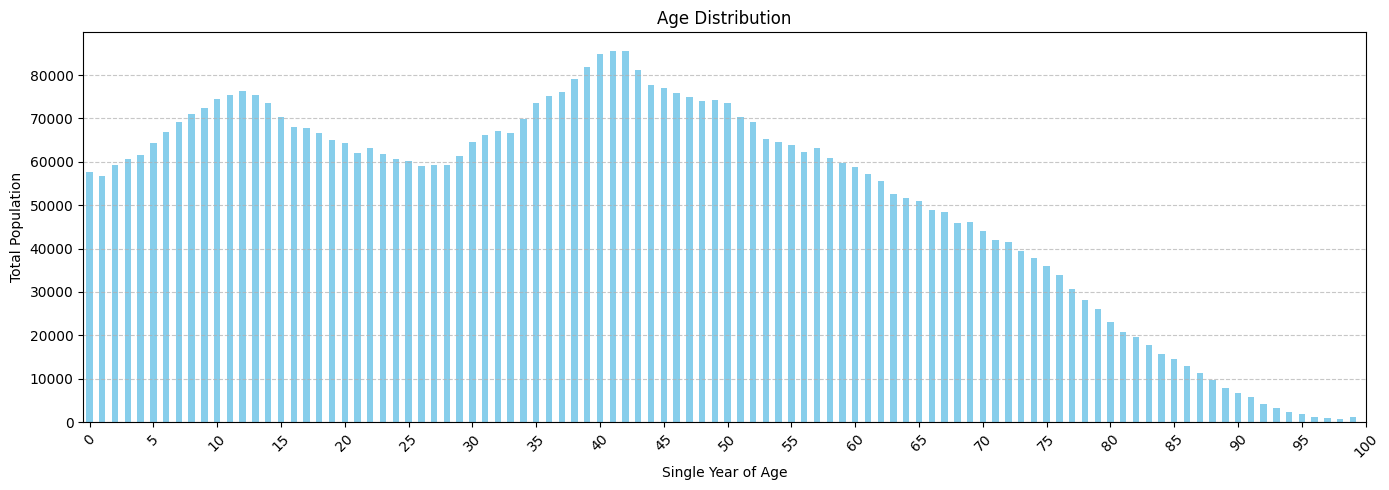

In [223]:
population_age_distribution_2022 = population_age_breakdown_df[population_age_breakdown_df['Year'] == 2022]

population_age_distribution = population_age_distribution_2022.groupby("Single Year of Age")["VALUE"].sum()

plt.figure(figsize=(14, 5))
population_age_distribution.plot(kind='bar', color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Single Year of Age")
plt.ylabel("Total Population")
plt.xticks(range(0, 101, 5), range(0, 101, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The bar chart visualizes the distribution of population across different ages for the given year (2022). 

There seems to be a higher number of individuals in the younger age categories. The bars are taller at the left side of the chart, indicating larger populations in younger age groups. The  same is true for the ages between 36 and 45. As the age increases, there is a general trend of decreasing population numbers. 

In [224]:
weighted_mean = np.average(population_age_distribution_2022["Single Year of Age"], weights=population_age_distribution_2022["VALUE"])

weighted_variance = np.average((population_age_distribution_2022["Single Year of Age"] - weighted_mean)**2, weights=population_age_distribution_2022["VALUE"])
weighted_std = np.sqrt(weighted_variance)

sorted_df = population_age_distribution_2022.sort_values(by="Single Year of Age")
cumsum = sorted_df["VALUE"].cumsum()
cutoff = cumsum.iloc[-1] / 2.0
weighted_median = sorted_df[sorted_df["VALUE"].cumsum() >= cutoff]["Single Year of Age"].iloc[0]

print(f"Variance: {weighted_variance}")
print(f"Mean: {weighted_mean:.8f}")
print(f"Median: {weighted_median:.8f}")
print(f"Std: {weighted_std:.8f}")

Variance: 520.713923652503
Mean: 38.37414636
Median: 38.00000000
Std: 22.81915694


I had to use the weighted mean as per the structure of the data.

From the above calculations we can see that the average age in Ireland for 2022 was 38.4 years. Compared with the official CSO data here - https://www.cso.ie/en/csolatestnews/pressreleases/2023pressreleases/pressstatementcensusofpopulation2022-summaryresults/#:~:text=The%20average%20age%20of%20the,a%2063%25%20increase%20from%202016. we can observe a difference of only 0.4 for the average value for 2022. 

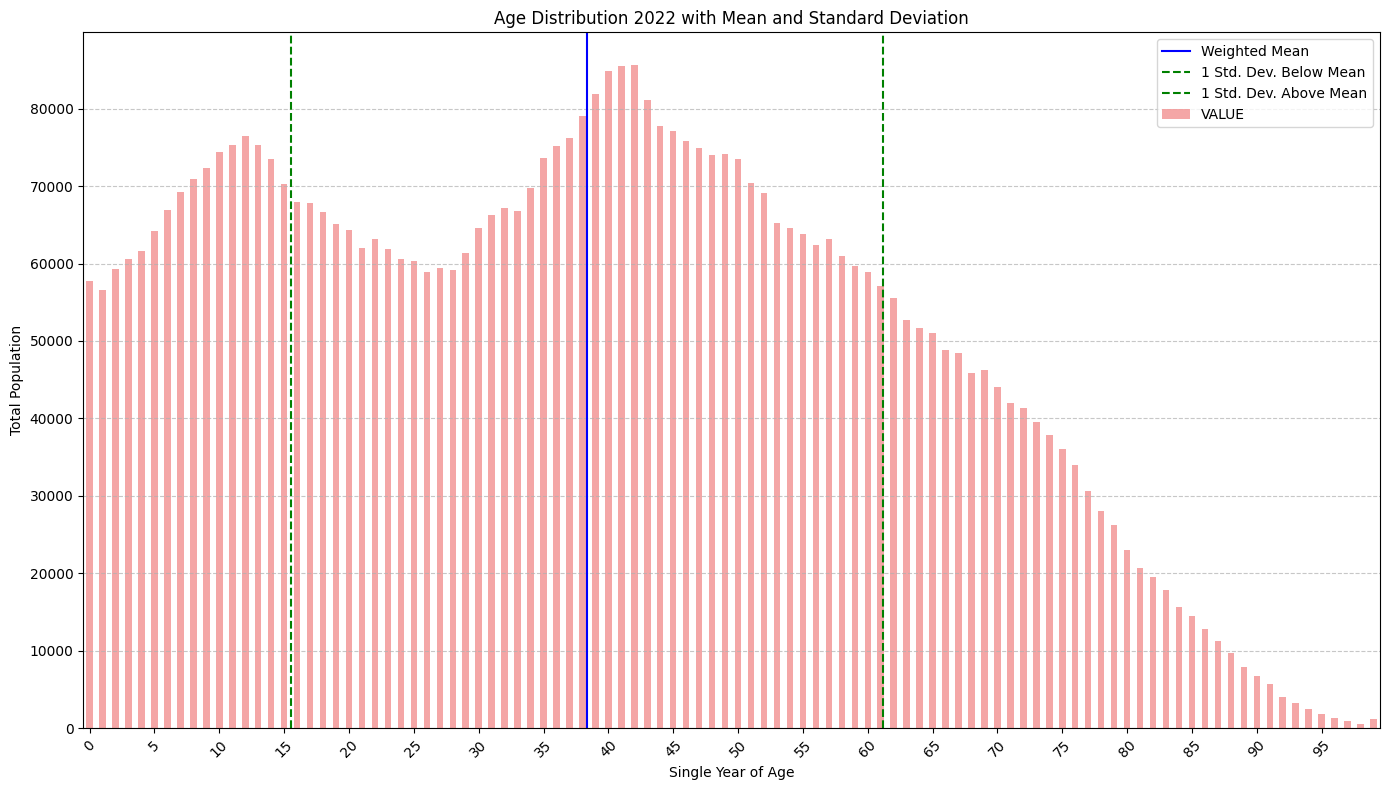

In [225]:
plt.figure(figsize=(14, 8))
population_age_distribution.plot(kind='bar', color='lightcoral', alpha=0.7)
plt.title("Age Distribution 2022 with Mean and Standard Deviation")
plt.xlabel("Single Year of Age")
plt.ylabel("Total Population")
plt.xticks(range(0, 100, 5), range(0, 100, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlighting the mean and standard deviation
plt.axvline(x=weighted_mean, color='blue', linestyle='-', label='Weighted Mean')
plt.axvline(x=weighted_mean - weighted_std, color='green', linestyle='--', label='1 Std. Dev. Below Mean')
plt.axvline(x=weighted_mean + weighted_std, color='green', linestyle='--', label='1 Std. Dev. Above Mean')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [226]:
def age_group(age):
    if age <= 14:
        return '0-14 years old'
    elif age <= 24:
        return '15-24 years old'
    elif age <= 44:
        return '25-44 years old'
    elif age <= 64:
        return '45-64 years old'
    else:
        return '65 and over'

population_age_breakdown_df['Age Group'] = population_age_breakdown_df['Single Year of Age'].apply(age_group)

population_age_breakdown_df


,Year,Age category,Single Year of Age,UNIT,VALUE,Age Group
5154,2013,200,0,Number,68583,0-14 years old
5157,2013,001,1,Number,71785,0-14 years old
5160,2013,002,2,Number,70638,0-14 years old
5163,2013,003,3,Number,71057,0-14 years old
5166,2013,004,4,Number,70956,0-14 years old
...,...,...,...,...,...,...
8469,2023,095,95,Number,2128,65 and over
8472,2023,096,96,Number,1581,65 and over
8475,2023,097,97,Number,1116,65 and over
8478,2023,098,98,Number,829,65 and over


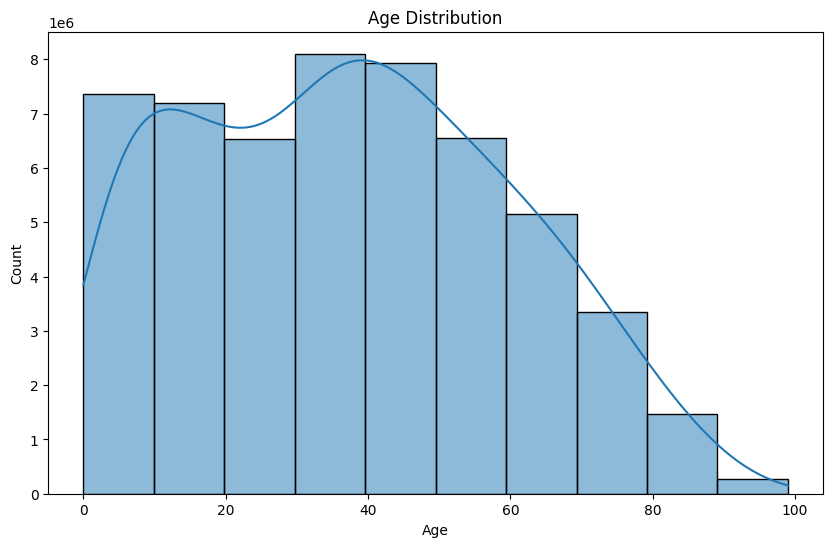

In [227]:
plt.figure(figsize=(10, 6))
sns.histplot(data=population_age_breakdown_df, x='Single Year of Age', weights='VALUE', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [228]:
population_age_breakdown_df

,Year,Age category,Single Year of Age,UNIT,VALUE,Age Group
5154,2013,200,0,Number,68583,0-14 years old
5157,2013,001,1,Number,71785,0-14 years old
5160,2013,002,2,Number,70638,0-14 years old
5163,2013,003,3,Number,71057,0-14 years old
5166,2013,004,4,Number,70956,0-14 years old
...,...,...,...,...,...,...
8469,2023,095,95,Number,2128,65 and over
8472,2023,096,96,Number,1581,65 and over
8475,2023,097,97,Number,1116,65 and over
8478,2023,098,98,Number,829,65 and over


In [229]:
population_pivot_age_groups = population_age_breakdown_df.pivot_table(index='Year', columns='Age Group', values='VALUE', aggfunc='sum')

population_pivot_age_groups = population_pivot_age_groups.reset_index()
population_pivot_age_groups.columns.name = None
population_pivot_age_groups

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
0,2013,993909,563278,1421081,1067215,569186
1,2014,997516,567222,1407323,1083895,589484
2,2015,1001705,571610,1400611,1103591,610270
3,2016,1005484,574697,1401520,1128049,629847
4,2017,1010356,587014,1403256,1157861,652408
5,2018,1014430,609252,1402768,1182019,676427
6,2019,1015539,623805,1406012,1211743,701372
7,2020,1013651,637923,1412015,1240171,726115
8,2021,1007602,640355,1411903,1267359,747449
9,2022,1014292,649717,1434196,1304462,781299


#### Binomial distribution

The binomial distribution is a way to figure out how likely it is to get a certain number of successes in a series of yes-or-no questions, where each question has the same chance of a yes

In [230]:
binom_pop_dataset = population_pivot_age_groups[population_pivot_age_groups['Year'] == 2022]
binom_pop_dataset

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
9,2022,1014292,649717,1434196,1304462,781299


In [231]:
probability_0_14= binom_pop_dataset['0-14 years old'].values[0] / 5185988

probability_0_14

0.1955831752792332

In [232]:
n = 100
k = 20
p = probability_0_14  

probability = binom.pmf(k, n, p)
print(probability)

0.0986899218478517


Using the binomial distribution, the function provides the probability of getting exactly 20 successes (people from the 0-14 age group) when conducting 100 trials (selecting 100 people).

The probability of selecting exactly 20 people from the "0-14 years old" age group when randomly choosing 100 people from the entire population is approximately 9.87%.

https://homepage.divms.uiowa.edu/~mbognar/applets/bin.html -- binomial distribution calculator

![binomial distribution](imgs/binom_calc.png)


As another example, I am interested in the probability of finding exactly 30 people from the '45-64 years old' age group when selecting 150 people at random. 


In [233]:
n_trials_new = 150    # Number of trials (selecting 150 people)
p_success_new = 1304462 / 5183966  # The probability of selecting someone from the 45-64 age group
k_successes_new = 30  # Number of successes we're interested in (people from the 45-64 age group)


binomial_probability_new = binom.pmf(k_successes_new, n_trials_new, p_success_new)
binomial_probability_new

0.026583077970737085

![binomial distribution2](imgs/binom2_calc.png)

The probability of selecting exactly 30 people from the "45-64 years old" age group when randomly choosing 150 people from the entire population is approximately 2.66%.

**Poisson distribution**

In my analysis, I will apply the Poisson distribution to model the number of immigration events, using historical data to determine lambda (λ), the average rate of immigration events per year.

Based on the dataset, the average rate of immigration (λ) is calculated to be approximately 12.16 events per year, while the mean emigration level is determined to be about 9.01 events per year.

To estimate the probability that the number of immigration events in a given year is less than the average number of emigration events, I use the cumulative distribution function (CDF) of the Poisson distribution. The CDF gives us the probability that the number of immigration events will be less than or equal to the average emigration level.

In [18]:
migration_df.head()

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02719V03286,Country,C02199V02655,Sex,C02542V03077,Origin or Destination,UNIT,VALUE
0,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,1,Net migration,Thousand,-13.7
1,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,4,Emigrants: All destinations,Thousand,21.8
2,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,8.1
3,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),1,Male,1,Net migration,Thousand,-9.0
4,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),1,Male,4,Emigrants: All destinations,Thousand,13.1


In [19]:
migration_df_for_poisson = migration_df[(migration_df['Sex'] == 'Both sexes') & (migration_df['Country'] == 'All countries')]


Getting the immigration and emigration, without any country or sex breakdown.

In [20]:
new_immigrants = migration_df_for_poisson[migration_df_for_poisson['Origin or Destination'] == 'Immigrants: All origins']['VALUE']
new_emigrants = migration_df_for_poisson[migration_df_for_poisson['Origin or Destination'] == 'Emigrants: All destinations']['VALUE']

new_mu_immigrants = new_immigrants.mean()
new_mu_emigrants = new_emigrants.mean()

# Calculate the probability that immigration is less than the mean emigration for the new dataset
new_probability_less_than_emigration = poisson.cdf(new_mu_emigrants, new_mu_immigrants)

new_mu_immigrants, new_mu_emigrants, new_probability_less_than_emigration


(65.4054054054054, 48.45945945945945, 0.014999878372018471)

Using the Poisson distribution with this data, the probability that the number of immigrant events in a year is less than the mean emigration level is approximately 0.228, or 22.8%. This suggests that, according to the data we have and the Poisson model, there is a 22.8% chance in any given year that immigration will be less than the average emigration.​​



![binomial distribution2](imgs/poisson_distr.png)

As I am comparing the the probability of immigration being less than the mean emigration level, which is approximateley 48, we type in 48 for X. for λ (Lambda) I need the average rate of success (mean number of immigrants per year) being 65.4054054054054.

The probability that the number of immigration events in a year is less than the mean emigration level, is approximately 0.015, or 1.5%. This suggests that, according to the Poisson model, there is a very low chance, specifically a 1.5% chance, that immigration will be less than the average emigration.

**Normal distribution**

In [21]:
migration_df_1996.head()

,Year,Country category,Country,Sex category,Sex,Migration label,Origin or Destination,UNIT,VALUE
0,1996,GB1,United Kingdom (1),-,Both sexes,1,Net migration,Thousand,3.5
1,1996,GB1,United Kingdom (1),-,Both sexes,4,Emigrants: All destinations,Thousand,14.1
2,1996,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,17.6
3,1996,GB1,United Kingdom (1),1,Male,1,Net migration,Thousand,1.7
4,1996,GB1,United Kingdom (1),1,Male,4,Emigrants: All destinations,Thousand,6.7


In [22]:
population_df_1996.head()

,Year,Age category,Single Year of Age,Sex category,Sex,UNIT,VALUE
0,1996,-,All ages,-,Both sexes,Number,3626087
1,1996,-,All ages,1,Male,Number,1800232
2,1996,-,All ages,2,Female,Number,1825855
3,1996,200,Under 1 year,-,Both sexes,Number,48854
4,1996,200,Under 1 year,1,Male,Number,25231


**Poisson distribution**

In my analysis, I will apply the Poisson distribution to model the number of immigration events, using historical data to determine lambda (λ), the average rate of immigration events per year.

Based on the dataset, the average rate of immigration (λ) is calculated to be approximately 12.16 events per year, while the mean emigration level is determined to be about 9.01 events per year.

To estimate the probability that the number of immigration events in a given year is less than the average number of emigration events, I use the cumulative distribution function (CDF) of the Poisson distribution. The CDF gives us the probability that the number of immigration events will be less than or equal to the average emigration level.

In [119]:
#migration_df.head()

In [120]:
migration_df_1996.head(30)

,Year,Country category,Country,Sex category,Sex,Migration label,Origin or Destination,UNIT,VALUE
0,1996,GB1,United Kingdom (1),-,Both sexes,1,Net migration,Thousand,3.5
1,1996,GB1,United Kingdom (1),-,Both sexes,4,Emigrants: All destinations,Thousand,14.1
2,1996,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,17.6
3,1996,GB1,United Kingdom (1),1,Male,1,Net migration,Thousand,1.7
4,1996,GB1,United Kingdom (1),1,Male,4,Emigrants: All destinations,Thousand,6.7
5,1996,GB1,United Kingdom (1),1,Male,5,Immigrants: All origins,Thousand,8.4
6,1996,GB1,United Kingdom (1),2,Female,1,Net migration,Thousand,1.8
7,1996,GB1,United Kingdom (1),2,Female,4,Emigrants: All destinations,Thousand,7.4
8,1996,GB1,United Kingdom (1),2,Female,5,Immigrants: All origins,Thousand,9.2
9,1996,US,United States,-,Both sexes,1,Net migration,Thousand,1.2


In [121]:
migration_df_for_poisson = migration_df_1996[(migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['Country'] == 'All countries')]


Getting the immigration and emigration, without any country or sex breakdown.

In [122]:
new_immigrants = migration_df_for_poisson[migration_df_for_poisson['Origin or Destination'] == 'Immigrants: All origins']['VALUE']
new_emigrants = migration_df_for_poisson[migration_df_for_poisson['Origin or Destination'] == 'Emigrants: All destinations']['VALUE']

new_mu_immigrants = new_immigrants.mean()
new_mu_emigrants = new_emigrants.mean()

# Calculate the probability that immigration is less than the mean emigration for the new dataset
new_probability_less_than_emigration = poisson.cdf(new_mu_emigrants, new_mu_immigrants)

new_mu_immigrants, new_mu_emigrants, new_probability_less_than_emigration


(76.91428571428571, 49.753571428571426, 0.00044075814312131186)

Using the Poisson distribution with this data, the probability that the number of immigrant events in a year is less than the mean emigration level is approximately 0.228, or 22.8%. This suggests that, according to the data we have and the Poisson model, there is a 22.8% chance in any given year that immigration will be less than the average emigration.​​



![binomial distribution2](imgs/poisson_distr.png)

As I am comparing the the probability of immigration being less than the mean emigration level, which is approximateley 48, we type in 48 for X. for λ (Lambda) I need the average rate of success (mean number of immigrants per year) being 65.4054054054054.

The probability that the number of immigration events in a year is less than the mean emigration level, is approximately 0.015, or 1.5%. This suggests that, according to the Poisson model, there is a very low chance, specifically a 1.5% chance, that immigration will be less than the average emigration.

**Normal distribution**

In [123]:
migration_df_1996.head()

,Year,Country category,Country,Sex category,Sex,Migration label,Origin or Destination,UNIT,VALUE
0,1996,GB1,United Kingdom (1),-,Both sexes,1,Net migration,Thousand,3.5
1,1996,GB1,United Kingdom (1),-,Both sexes,4,Emigrants: All destinations,Thousand,14.1
2,1996,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,17.6
3,1996,GB1,United Kingdom (1),1,Male,1,Net migration,Thousand,1.7
4,1996,GB1,United Kingdom (1),1,Male,4,Emigrants: All destinations,Thousand,6.7


In [124]:
population_df_1996.head()

,Year,Age category,Single Year of Age,Sex category,Sex,UNIT,VALUE
0,1996,-,All ages,-,Both sexes,Number,3626087
1,1996,-,All ages,1,Male,Number,1800232
2,1996,-,All ages,2,Female,Number,1825855
3,1996,200,Under 1 year,-,Both sexes,Number,48854
4,1996,200,Under 1 year,1,Male,Number,25231


Growth Rate=(Current Year Population - Previous Year Population / Previous Year Population)×100

In [234]:
growth_rates_df = population_pivot_age_groups.set_index('Year').pct_change() * 100

growth_rates_df = growth_rates_df.reset_index()
growth_rates_df

,Year,0-14 years old,15-24 years old,25-44 years old,45-64 years old,65 and over
0,2013,NaN,NaN,NaN,NaN,NaN
1,2014,0.362910,0.700187,-0.968136,1.562947,3.566145
2,2015,0.419943,0.773595,-0.476934,1.817150,3.526135
3,2016,0.377257,0.540054,0.064900,2.216220,3.207924
4,2017,0.484543,2.143216,0.123866,2.642793,3.581981
5,2018,0.403224,3.788325,-0.034776,2.086434,3.681592
6,2019,0.109322,2.388667,0.231257,2.514680,3.687759
7,2020,-0.185911,2.263207,0.426952,2.346042,3.527800
8,2021,-0.596754,0.381237,-0.007932,2.192278,2.938102
9,2022,0.663953,1.462002,1.578933,2.927584,4.528737


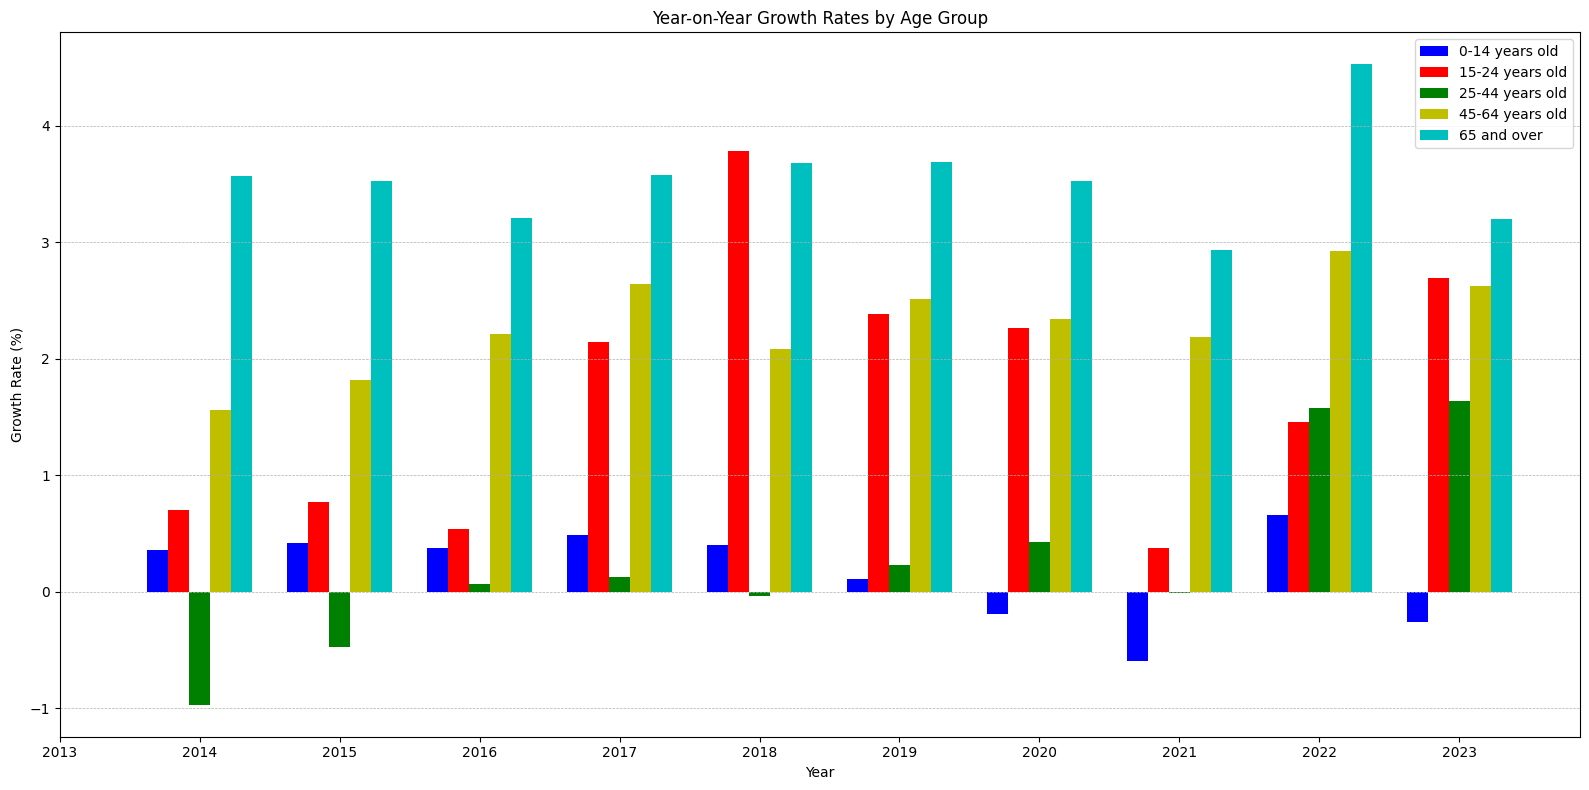

In [235]:
bar_width = 0.15
years = growth_rates_df['Year']
index = range(len(years))
colors = ['b', 'r', 'g', 'y', 'c']

plt.figure(figsize=(16, 8))

for idx, column in enumerate(growth_rates_df.columns[1:]):
    plt.bar(
        [i + idx * bar_width for i in index],
        growth_rates_df[column],
        width=bar_width,
        label=column,
        color=colors[idx]
    )

plt.title('Year-on-Year Growth Rates by Age Group')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.xticks([i + 2 * bar_width for i in index], years)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

 The "65 and over" category generally has higher growth rates, indicating a faster-growing elderly population compared to other age groups.

 The "0-14 years old" category shows fluctuations in growth rate, with some years showing negative growth.

 The "65 and over" category has a significant spike in 2022, which is the highest among all categories and years, suggesting a recent increase in the aging population or an anomaly in the data.

In [236]:
population_pivot_age_groups['Total Population'] = population_pivot_age_groups.sum(axis=1)

population_pivot_age_groups['Total Growth Rate'] = population_pivot_age_groups['Total Population'].pct_change() * 100

population_pivot_age_groups[['Year', 'Total Population', 'Total Growth Rate']]


,Year,Total Population,Total Growth Rate
0,2013,4616682,NaN
1,2014,4647454,0.666539
2,2015,4689802,0.911209
3,2016,4741613,1.104759
4,2017,4812912,1.503687
5,2018,4886914,1.537572
6,2019,4960490,1.505572
7,2020,5031895,1.439475
8,2021,5076689,0.890201
9,2022,5185988,2.152958


In [237]:
max_growth_year = population_pivot_age_groups.loc[population_pivot_age_groups['Total Growth Rate'].idxmax(), 'Year']
min_growth_year = population_pivot_age_groups.loc[population_pivot_age_groups['Total Growth Rate'].idxmin(), 'Year']
highest_growth_rate = population_pivot_age_groups['Total Growth Rate'].max()
lowest_growth_rate = population_pivot_age_groups['Total Growth Rate'].min()

dominant_age_groups = growth_rates_df.drop(columns='Year').idxmax(axis=1)

aligned_growth_rates_df, aligned_total_growth = growth_rates_df.set_index('Year').align(
    population_pivot_age_groups.set_index('Year')['Total Growth Rate'], axis=1)

age_groups_above_total = (aligned_growth_rates_df > aligned_total_growth).sum()
age_groups_below_total = (aligned_growth_rates_df < aligned_total_growth).sum()

growth_rate_std = growth_rates_df.drop(columns='Year').std()

print(f"Year with maximum growth: {max_growth_year} with a growth rate of: {highest_growth_rate:.6f}")
print(f"Year with minimum growth: {min_growth_year} with a growth rate of: {lowest_growth_rate:.6f}\n")

print("Dominant age groups by year:")
for year, age_group in dominant_age_groups.items():
    print(f"  {year}: {age_group}")

Year with maximum growth: 2022 with a growth rate of: 2.152958
Year with minimum growth: 2014 with a growth rate of: 0.666539

Dominant age groups by year:
  0: nan
  1: 65 and over
  2: 65 and over
  3: 65 and over
  4: 65 and over
  5: 15-24 years old
  6: 65 and over
  7: 65 and over
  8: 65 and over
  9: 65 and over
  10: 65 and over


We can see that for all the years in the dataset, except of the year 2018, the age group 65 and over had the highest growth rate. In 2018, the 15-24 years old had the highest growth rate. 

In [238]:
print("Standard deviation of the growth rate across age groups:")
for age_group, std_value in growth_rate_std.items():
    print(f"  {age_group}: {std_value:.6f}")

Standard deviation of the growth rate across age groups:
  0-14 years old: 0.400539
  15-24 years old: 1.122137
  25-44 years old: 0.812438
  45-64 years old: 0.409218
  65 and over: 0.423033


**Overall Population Growth:**

The year with the highest overall growth rate was 2022, with a growth rate of approximately 
2.15
%
The year with the lowest overall growth rate was 2014, with a growth rate of approximately 
0.67
%
Age Group Dominance:

The "65 and over" age group had the highest growth rate in most of the years. This suggests that the elderly population has been growing at a faster rate than other age groups in many years.


In [239]:
total_growth_trend = population_pivot_age_groups['Total Growth Rate'].dropna().diff().mean()

age_group_contributions = population_pivot_age_groups.drop(columns=['Year', 'Total Population', 'Total Growth Rate']).diff().sum()

age_group_trends = growth_rates_df.drop(columns='Year').mean()

most_volatile_age_group = growth_rate_std.idxmax()
least_volatile_age_group = growth_rate_std.idxmin()

print(f"Yearly total growth trend: {total_growth_trend:.6f}")

print("\nAge group contributions:")
for group, contribution in age_group_contributions.items():
    print(f"{group}: {contribution:.1f}")

print("\nAge group trends:")
for group, trend in age_group_trends.items():
    print(f"{group}: {trend:.6f}")

print(f"\nMost volatile age group: {most_volatile_age_group}")
print(f"Least volatile age group: {least_volatile_age_group}")

Yearly total growth trend: 0.135151

Age group contributions:
0-14 years old: 17730.0
15-24 years old: 103937.0
25-44 years old: 36642.0
45-64 years old: 271524.0
65 and over: 237110.0

Age group trends:
0-14 years old: 0.177693
15-24 years old: 1.713366
25-44 years old: 0.257856
45-64 years old: 2.293380
65 and over: 3.544559

Most volatile age group: 15-24 years old
Least volatile age group: 0-14 years old


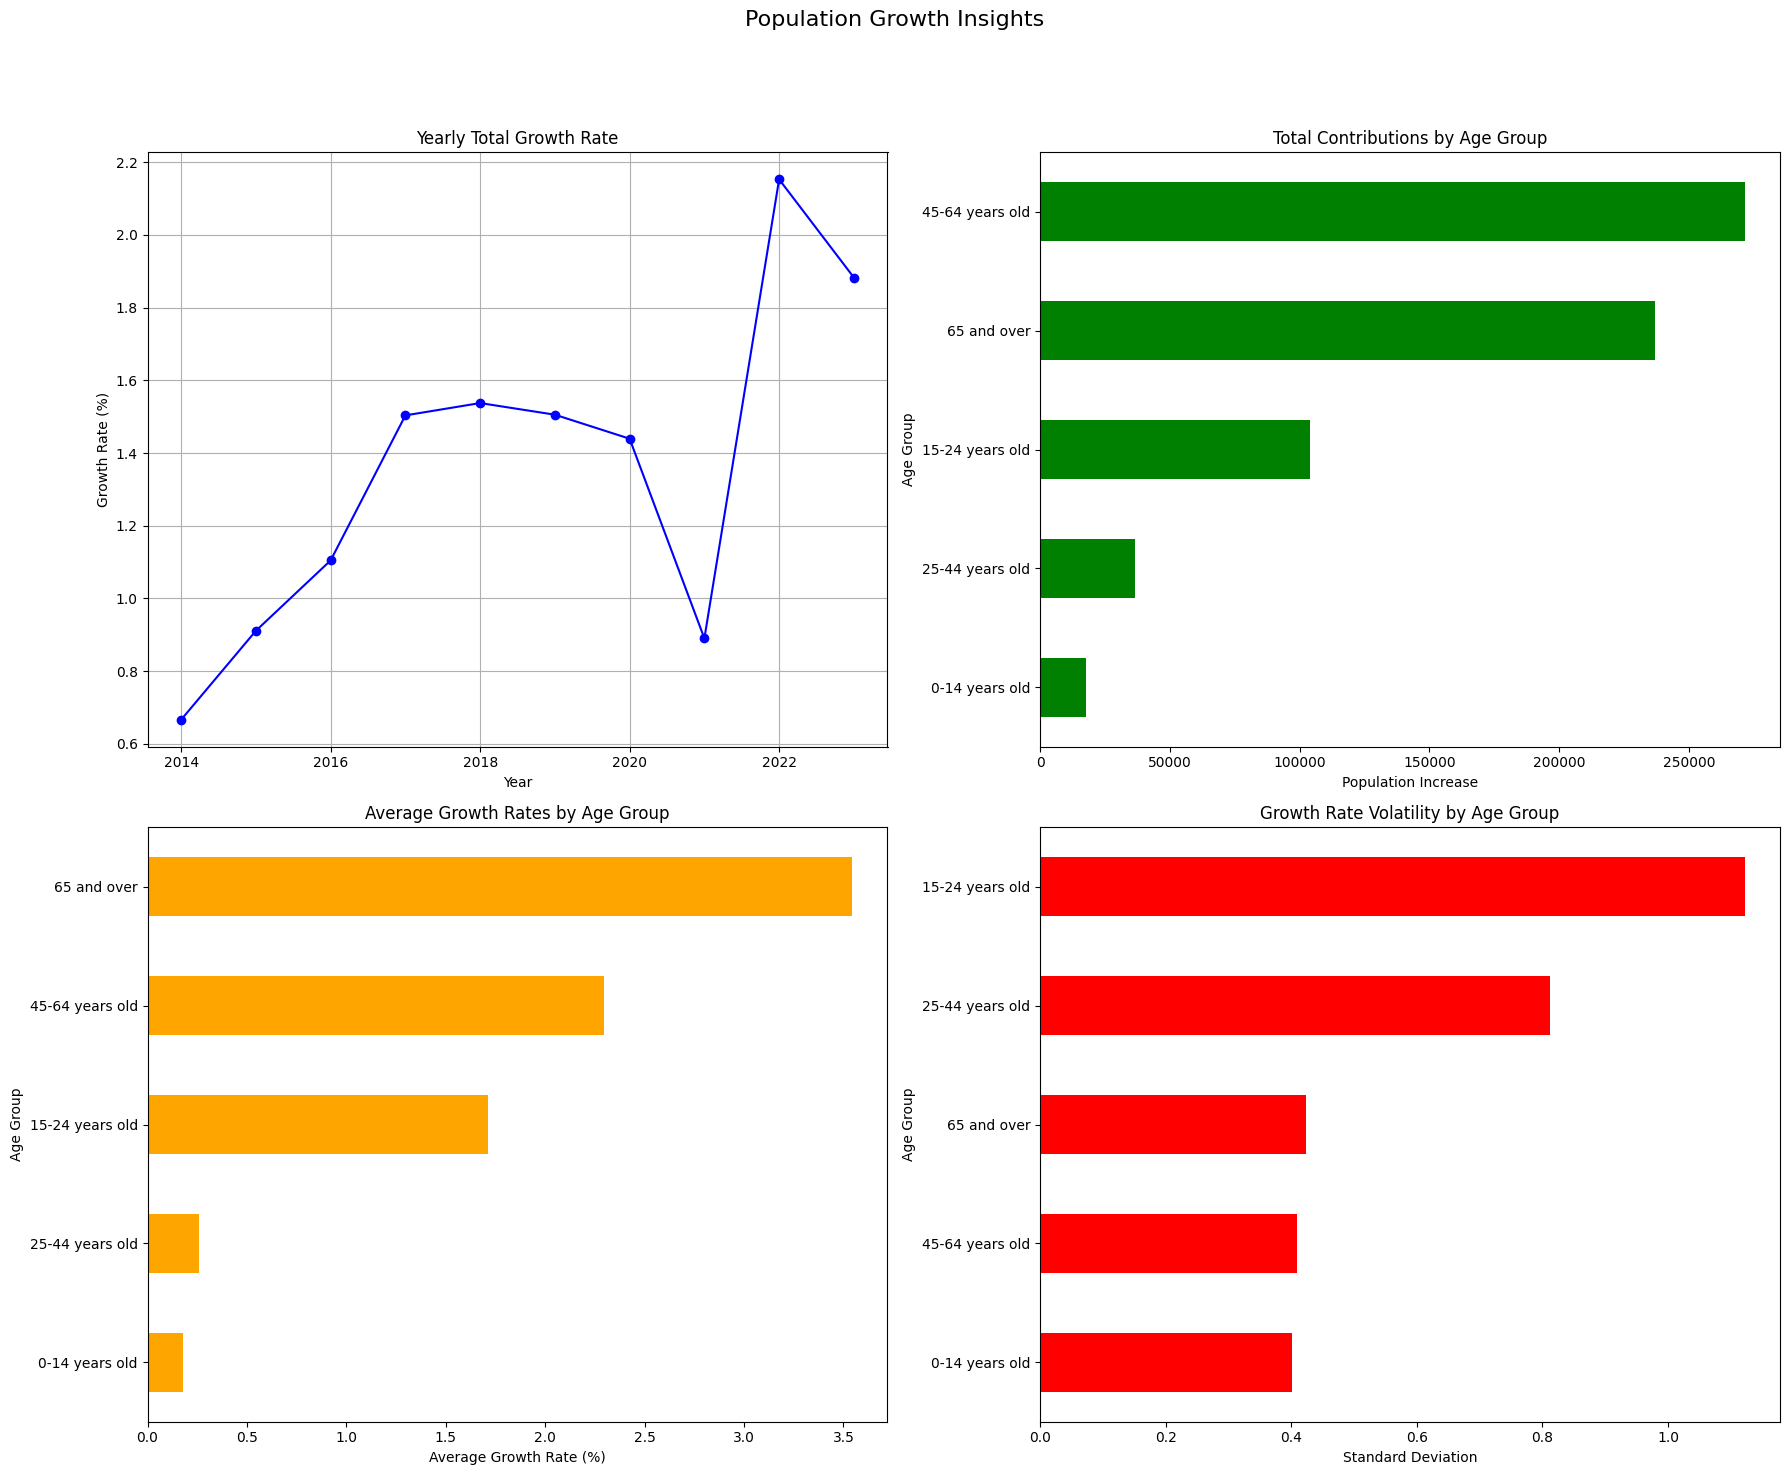

In [240]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
fig.suptitle('Population Growth Insights', fontsize=16, y=1.05)

# Line plot of yearly total growth rate
axes[0, 0].plot(population_pivot_age_groups['Year'], population_pivot_age_groups['Total Growth Rate'], marker='o', color='blue')
axes[0, 0].set_title('Yearly Total Growth Rate')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Growth Rate (%)')
axes[0, 0].grid(True)

# Bar plot of age group contributions
age_group_contributions.sort_values().plot(kind='barh', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Total Contributions by Age Group')
axes[0, 1].set_xlabel('Population Increase')
axes[0, 1].set_ylabel('Age Group')

# Bar plot of average growth rates by age group
age_group_trends.sort_values().plot(kind='barh', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Average Growth Rates by Age Group')
axes[1, 0].set_xlabel('Average Growth Rate (%)')
axes[1, 0].set_ylabel('Age Group')

# Bar plot of growth rate volatility
growth_rate_std.sort_values().plot(kind='barh', ax=axes[1, 1], color='red')
axes[1, 1].set_title('Growth Rate Volatility by Age Group')
axes[1, 1].set_xlabel('Standard Deviation')
axes[1, 1].set_ylabel('Age Group')

plt.tight_layout()
plt.show()

**Yearly Total Growth Analysis:**

The average change in the yearly total growth rate is approximately 
0.135
%
This value indicates the average yearly change in the growth rate. Since it's positive, it suggests that the growth rate has been increasing on average year over year, but the magnitude of the change is relatively small.

Age Group Impact:

The "45-64 years old" age group has contributed the most to the total population growth with an increase of approximately 271,524 people over the years.
The "65 and over" age group follows closely with an increase of approximately 237,110 people.
The "0-14 years old" age group has had the least contribution to growth with only an increase of about 17,730 people.
Age Group Trends:

On average, the "65 and over" age group has the highest growth rate at approximately 
3.54
%

The "15-24 years old" age group follows with an average growth rate of approximately 
1.71
%

The "0-14 years old" age group has the lowest average growth rate at around 
0.18
%



The "15-24 years old" age group has shown the most fluctuation in its growth rate over the years, as indicated by its highest standard deviation.
The "0-14 years old" age group has the least variability in its growth rates, making it the most stable.

Migration data visualizations

In [241]:
immigration_df = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Immigrants: All origins') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['Year'] >= 2000) & (migration_df_1996['Country'] != 'All countries')]
immigration_df

,Year,Country category,Country,Sex category,Sex,Migration label,Origin or Destination,UNIT,VALUE
182,2000,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,20.8
191,2000,US,United States,-,Both sexes,5,Immigrants: All origins,Thousand,5.5
200,2000,ZZWORX23,Other countries (23),-,Both sexes,5,Immigrants: All origins,Thousand,14.5
218,2000,E1420XIE,EU14 excl Irl (UK & Ireland),-,Both sexes,5,Immigrants: All origins,Thousand,11.7
227,2001,GB1,United Kingdom (1),-,Both sexes,5,Immigrants: All origins,Thousand,20.6
...,...,...,...,...,...,...,...,...,...
1667,2023,CA,Canada,-,Both sexes,5,Immigrants: All origins,Thousand,7.2
1676,2023,AU,Australia,-,Both sexes,5,Immigrants: All origins,Thousand,7.7
1685,2023,ZZWORX23,Other countries (23),-,Both sexes,5,Immigrants: All origins,Thousand,75.8
1703,2023,E1420XIE,EU14 excl Irl (UK & Ireland),-,Both sexes,5,Immigrants: All origins,Thousand,17.7


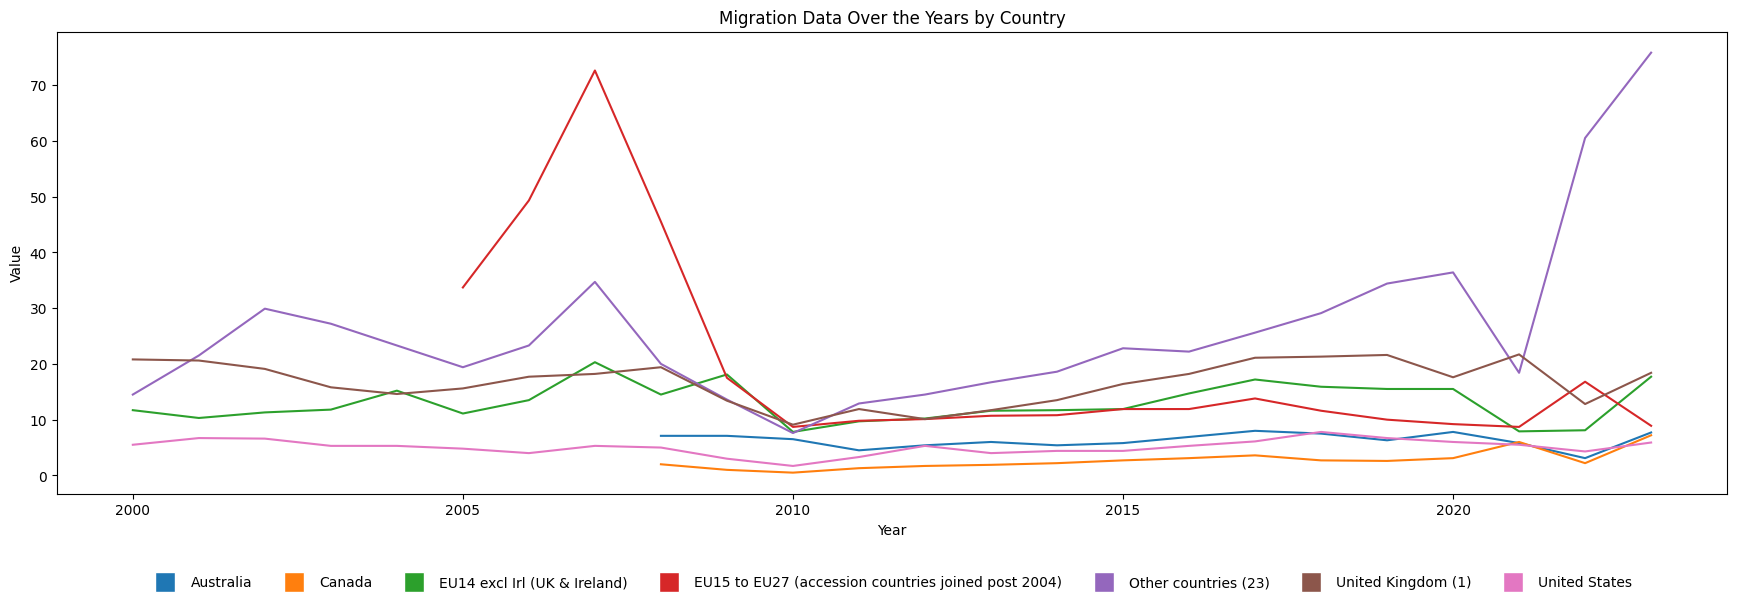

In [242]:
plt.figure(figsize=(21.55, 6))
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
legend_elements = []

pivot_table_immigration = immigration_df.pivot_table(index='Year', columns='Country', values='VALUE', aggfunc= 'sum')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Migration Data Over the Years by Country')

for i, country in enumerate(pivot_table_immigration.columns):
    color = colors[i]
    plt.plot(pivot_table_immigration.index, pivot_table_immigration[country], color, label=country)
    #legend_elements.append(Line2D([0], [0], color=color, label=country))
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color,label=country, markersize=15))

plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=8, frameon=False)
plt.show()

In [243]:
immigration_df_all_countries_total = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Immigrants: All origins') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['Year'] >= 2015) & (migration_df_1996['Country'] == 'All countries')]
immigration_df_all_countries_total

,Year,Country category,Country,Sex category,Sex,Migration label,Origin or Destination,UNIT,VALUE
1118,2015,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,75.9
1190,2016,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,82.3
1262,2017,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,95.3
1334,2018,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,96.0
1406,2019,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,97.1
1478,2020,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,95.6
1550,2021,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,74.1
1622,2022,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,107.8
1694,2023,-,All countries,-,Both sexes,5,Immigrants: All origins,Thousand,141.6


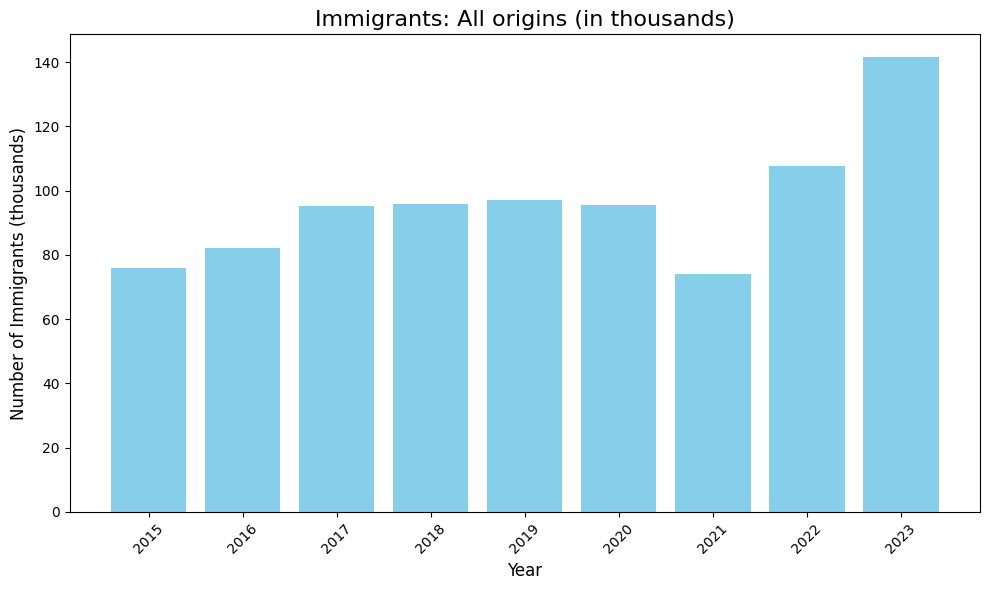

In [244]:

# Data for creating the bar chart
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
values = [75.9, 82.3, 95.3, 96.0, 97.1, 95.6, 74.1, 107.8, 141.6]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, values, color='skyblue')

# Title and labels
plt.title('Immigrants: All origins (in thousands)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Immigrants (thousands)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()

In [245]:
emigrants_1996 = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Emigrants: All destinations') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['VALUE'] != 'NaN') & (migration_df_1996['Country'] == 'All countries')]
immigrants_1996 = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Immigrants: All origins') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['VALUE'] != 'NaN') & (migration_df_1996['Country'] == 'All countries')]
net_migration_1996 = migration_df_1996[(migration_df_1996['Origin or Destination'] == 'Net migration') & (migration_df_1996['Sex'] == 'Both sexes') & (migration_df_1996['VALUE'] != 'NaN') & (migration_df_1996['Country'] == 'All countries')]
migration_years_1996 = migration_df_1996['Year'].unique()
emigrants_values_1996 = emigrants_1996['VALUE'].values
immigrants_values_1996 = immigrants_1996['VALUE'].values
net_migration_values_1996 = net_migration_1996['VALUE'].values


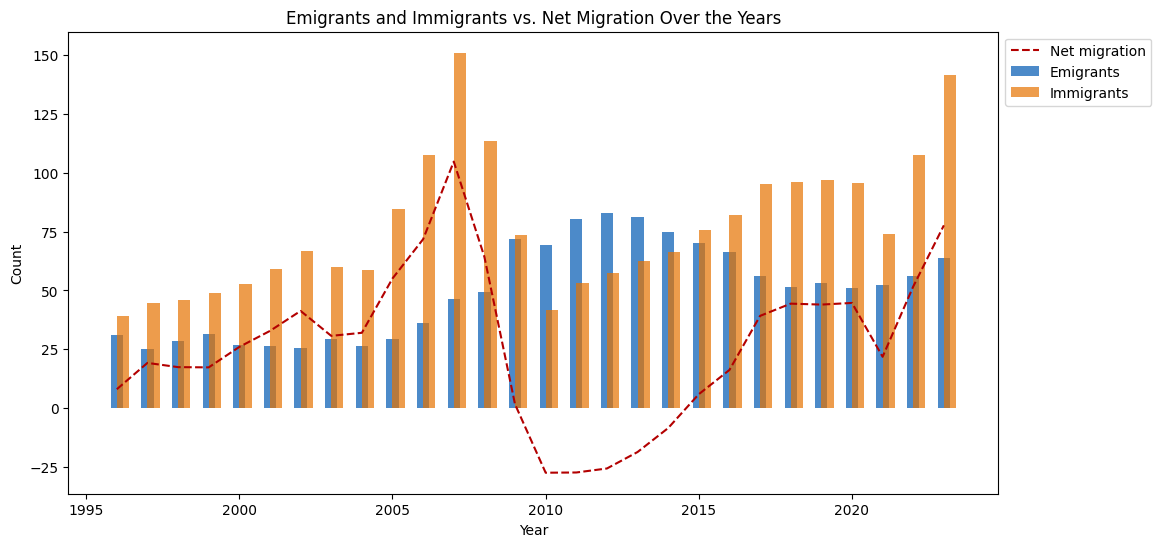

In [246]:
plt.figure(figsize=(12,6))

plt.bar(migration_years_1996, emigrants_values_1996, label='Emigrants', color='#0059b3', alpha=0.7, width=0.4)
plt.bar(migration_years_1996, immigrants_values_1996, label='Immigrants', color='#e67300', alpha=0.7, width=0.4, align='edge')


plt.plot(migration_years_1996, net_migration_values_1996, label='Net migration', marker='', linestyle='--', color='#b30000')

plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.title('Emigrants and Immigrants vs. Net Migration Over the Years')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [138]:
asdfghjkl

NameError: name 'asdfghjkl' is not defined

### ML Linear Regression

In [300]:
filtered_BothSex = population_df[(population_df['Single Year of Age'] == 'All ages') & (population_df['Sex'] == 'Both sexes') & (population_df['Year'] >= 2003)]
filtered_BothSex

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02076V03371,Single Year of Age,C02199V02655,Sex,UNIT,VALUE
5454,PEA11,Population estimates from 1926,2003,2003,-,All ages,-,Both sexes,Number,3979853
5757,PEA11,Population estimates from 1926,2004,2004,-,All ages,-,Both sexes,Number,4045188
6060,PEA11,Population estimates from 1926,2005,2005,-,All ages,-,Both sexes,Number,4133839
6363,PEA11,Population estimates from 1926,2006,2006,-,All ages,-,Both sexes,Number,4232929
6666,PEA11,Population estimates from 1926,2007,2007,-,All ages,-,Both sexes,Number,4375842
6969,PEA11,Population estimates from 1926,2008,2008,-,All ages,-,Both sexes,Number,4485070
7272,PEA11,Population estimates from 1926,2009,2009,-,All ages,-,Both sexes,Number,4533395
7575,PEA11,Population estimates from 1926,2010,2010,-,All ages,-,Both sexes,Number,4554763
7878,PEA11,Population estimates from 1926,2011,2011,-,All ages,-,Both sexes,Number,4574888
8181,PEA11,Population estimates from 1926,2012,2012,-,All ages,-,Both sexes,Number,4593697


In [301]:
filtered_BothSex= filtered_BothSex.drop(['STATISTIC', 'STATISTIC Label', 'TLIST(A1)', 'Single Year of Age', 'Sex', 'UNIT', 'C02076V03371', 'C02199V02655'], axis =1)
filtered_BothSex


,Year,VALUE
5454,2003,3979853
5757,2004,4045188
6060,2005,4133839
6363,2006,4232929
6666,2007,4375842
6969,2008,4485070
7272,2009,4533395
7575,2010,4554763
7878,2011,4574888
8181,2012,4593697


In [329]:
filtered_BothSex.to_csv('test_for_time_series.csv')

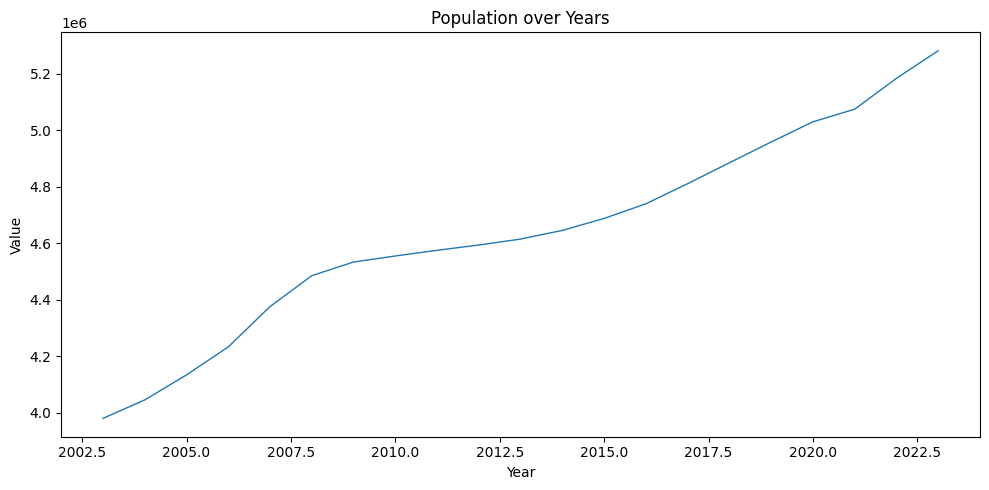

In [273]:
# Plotting
plt.figure(figsize=(10, 5))

# Generate yearly ticks from the start to the end of the dataset
xticks = pd.date_range(start=filtered_BothSex['Year'].min(), end=filtered_BothSex['Year'].max(), freq='YS')


# Plot the values
plt.plot(filtered_BothSex['Year'], filtered_BothSex['VALUE'], linewidth=1)

# Set the labels
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Population over Years")

# Show the plot
plt.tight_layout()
plt.show()


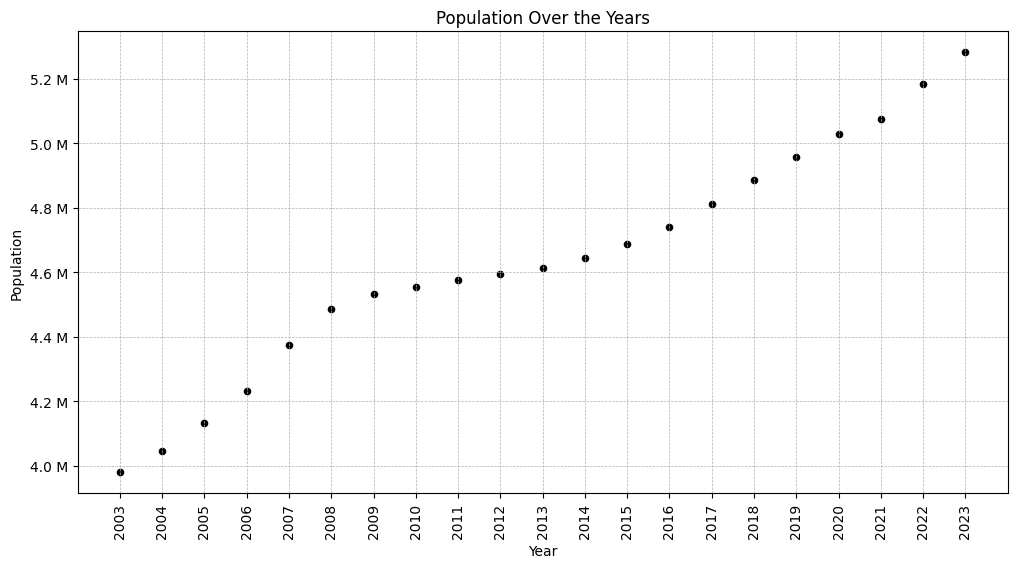

In [274]:
filtered_BothSex.plot(kind='scatter', x='Year', y='VALUE', figsize=(12, 6) ,color='black')

plt.title('Population Over the Years')
plt.xlabel('Year')
plt.ylabel('Population')
years = filtered_BothSex['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

In [275]:
X = filtered_BothSex[['Year']]
y = filtered_BothSex['VALUE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

X_train, y_train


(       Year
 8484   2013
 9696   2017
 10908  2021
 7272   2009
 11211  2022
 6666   2007
 6060   2005
 6969   2008
 10302  2019
 8181   2012
 7575   2010
 10605  2020
 6363   2006
 5454   2003
 9999   2018
 9090   2015,
 8484     4614669
 9696     4810895
 10908    5074668
 7272     4533395
 11211    5183966
 6666     4375842
 6060     4133839
 6969     4485070
 10302    4958471
 8181     4593697
 7575     4554763
 10605    5029875
 6363     4232929
 5454     3979853
 9999     4884896
 9090     4687787
 Name: VALUE, dtype: int64)

In [276]:

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

#future_years = [2050, 2060, 2070]  # years we want to predict
future_years = [2050] 
future_data = pd.DataFrame({'Year': future_years})
predicted_population = model.predict(future_data)
print(f'Predicted population to {future_years[0]} is {predicted_population[0]:.0f}')


R-squared: 0.964272256633945
Predicted population to 2050 is 6678149


https://www.cso.ie/en/releasesandpublications/ep/p-plfp/populationandlabourforceprojections2017-2051/populationprojectionsresults/?fbclid=IwAR0y2ch0t6PVr-Rbk_qAo7pzcDPPPqGXHRWB4wnp5B9MK39WAtVmeEPauWo 

When compared to the Central Statistic Office we see that our estimated value of 6.7M is the same as the one we see on the Statistics Office. 

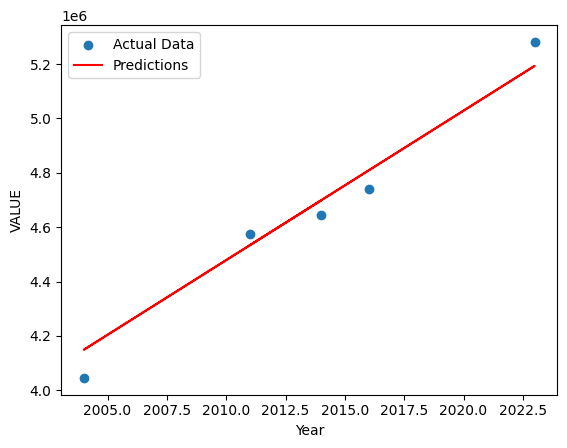

In [277]:
plt.scatter(X_test, y_test, label='Actual Data')
plt.plot(X_test, y_pred, color='red', label='Predictions')
plt.xlabel('Year')
plt.ylabel('VALUE')
plt.legend()
plt.show()

**Trying to convert to timeseries**

In [302]:
filtered_BothSex['Year'] = pd.to_datetime(filtered_BothSex['Year'], format='%Y')
filtered_BothSex.set_index('Year', inplace=True)
filtered_BothSex

,VALUE
Year,
2003-01-01,3979853
2004-01-01,4045188
2005-01-01,4133839
2006-01-01,4232929
2007-01-01,4375842
2008-01-01,4485070
2009-01-01,4533395
2010-01-01,4554763
2011-01-01,4574888


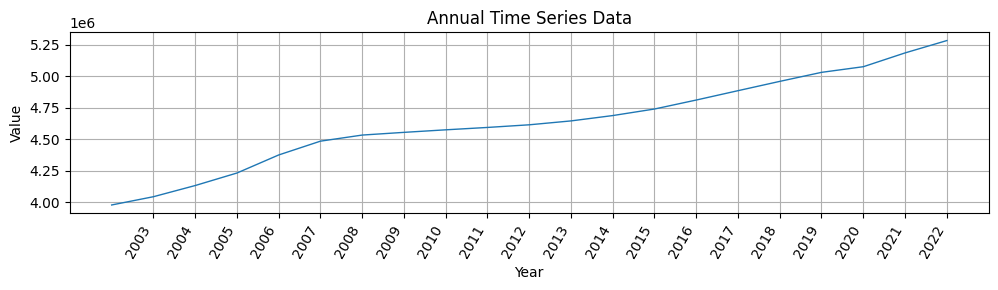

In [284]:
# Plotting the time series data with annual frequency
plt.figure(figsize=(10, 3))

# Generate x-ticks for each year in the dataset
xticks = pd.date_range(start=filtered_BothSex.index.min(), end=filtered_BothSex.index.max(), freq='A-DEC')

# Set the date format for the plot
plt.xticks(xticks, xticks.strftime("%Y"), rotation=60, ha="right")

# Plot the data
plt.plot(filtered_BothSex.index, filtered_BothSex['VALUE'], linewidth=1)
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Annual Time Series Data")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [305]:
filtered_BothSex.index.astype("int64").values
filtered_BothSex.values

array([[3979853],
       [4045188],
       [4133839],
       [4232929],
       [4375842],
       [4485070],
       [4533395],
       [4554763],
       [4574888],
       [4593697],
       [4614669],
       [4645440],
       [4687787],
       [4739597],
       [4810895],
       [4884896],
       [4958471],
       [5029875],
       [5074668],
       [5183966],
       [5281612]], dtype=int64)

In [306]:
filtered_BothSex.index.astype("int64").values.reshape(-1, 1)

array([[1041379200000000000],
       [1072915200000000000],
       [1104537600000000000],
       [1136073600000000000],
       [1167609600000000000],
       [1199145600000000000],
       [1230768000000000000],
       [1262304000000000000],
       [1293840000000000000],
       [1325376000000000000],
       [1356998400000000000],
       [1388534400000000000],
       [1420070400000000000],
       [1451606400000000000],
       [1483228800000000000],
       [1514764800000000000],
       [1546300800000000000],
       [1577836800000000000],
       [1609459200000000000],
       [1640995200000000000],
       [1672531200000000000]], dtype=int64)

In [307]:
X = filtered_BothSex.index.astype("int64").values.reshape(-1, 1)  # Features
y = filtered_BothSex['VALUE'].values 

X.shape, y.shape

((21, 1), (21,))

In [344]:
n_train = 13

# Adjust the eval_on_features function to work with the provided dataset
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    
    regressor.fit(X_train, y_train)
    y_pred_test = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    # Calculate R^2 score for test set
    test_score = r2_score(y_test, y_pred_test)
    print(f"Test-set R^2: {test_score:.2f}")
    
    # Plotting the results
    plt.figure(figsize=(10, 3))
    
    # Generate x-ticks for each year in the dataset
    xticks = pd.date_range(start=filtered_BothSex.index.min(), end=filtered_BothSex.index.max(), freq='A-DEC')
    
    # Plot the training and test sets along with the predictions
    plt.plot(filtered_BothSex.index[:n_train], y_train, label="train")
    plt.plot(filtered_BothSex.index[n_train:], y_test, label="test")
    plt.plot(filtered_BothSex.index[:n_train], y_pred_train, '--', label="prediction train")
    plt.plot(filtered_BothSex.index[n_train:], y_pred_test, '--', label="prediction test")
    
    # Formatting the plot
    plt.xticks(xticks, xticks.strftime("%Y"), rotation=90)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title("Time Series Prediction")
    plt.tight_layout()
    plt.show()

Test-set R^2: 0.89


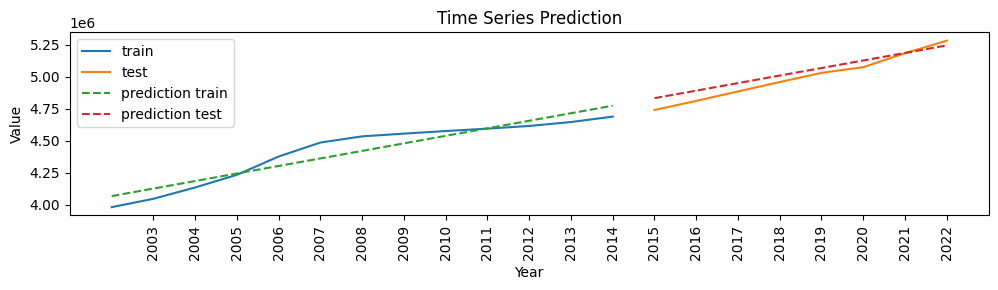

In [343]:
eval_on_features(X, y, LinearRegression())

Test-set R^2: -3.61


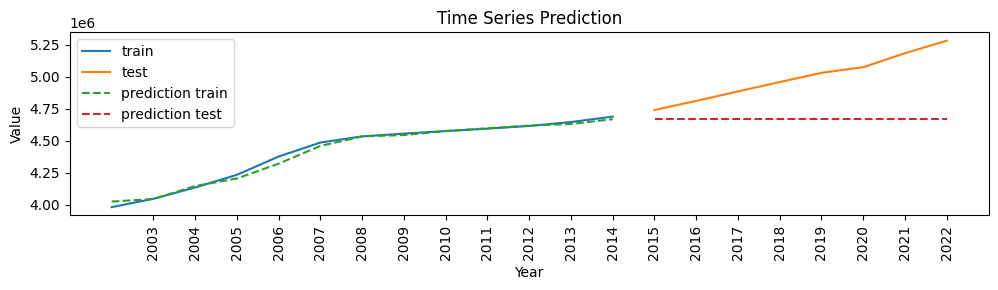

In [327]:
from sklearn.ensemble import RandomForestRegressor

# Create an object 'regressor' by calling a method RandomForestRegressor()
regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)

# Call the method eval_on_features() to calculate the R^2 and plot
eval_on_features(X, y, regressor)

In [323]:
# import OneHotEncoder from sklearn
from sklearn.preprocessing import OneHotEncoder

# Declare an object (enc) by calling a method OneHotEncoder()
enc = OneHotEncoder()

# Create an array by calling a fit() method
X_year_onehot = enc.fit_transform(X).toarray()

X_year_onehot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

Test-set R^2: -11.14


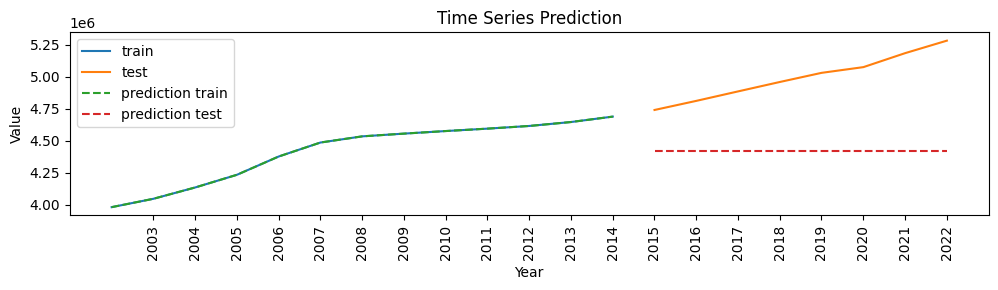

In [324]:
# import LinearRegression library from sklearn
from sklearn.linear_model import LinearRegression

# Call a method eval_on_features() to evaluate R^2 and plot
eval_on_features(X_year_onehot, y, LinearRegression())

Test-set R^2: 0.89


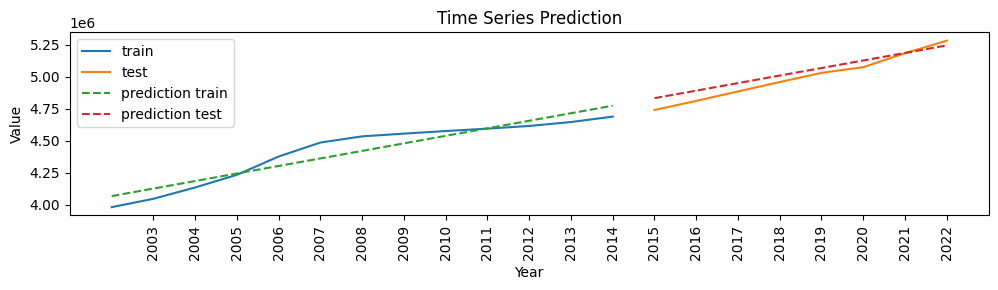

In [328]:
# import a library (Ridge) from sklearn
from sklearn.linear_model import Ridge

# Call a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X, y, Ridge())

Test-set R^2: -11.14


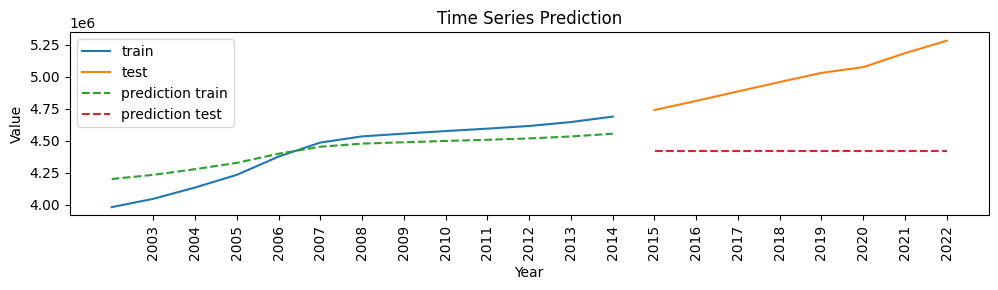

In [326]:
# import polynomial library from sklearn
from sklearn.preprocessing import PolynomialFeatures
# https://en.wikipedia.org/wiki/Polynomial_regression
# y = ax + b: Linear Regression, y = ax^2 + bx + x: Polynomial Regression

# Create and initialise an object named as PolynomialFeatures()
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

# Call fit() method to train the model
X_year_nehot_poly = poly_transformer.fit_transform(X_year_onehot)

# Initialise an object by calling a method Ridge()
lr = Ridge()

# Call a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X_year_nehot_poly, y, lr)

### Net Migration KNN and Decision Tree

In [255]:
migration_df_for_ml = pd.read_csv('PEA18.20231016T141007.csv')

In [256]:
new_migration_for_analysis = migration_df_for_ml[(migration_df_for_ml['Country'] != 'All countries') & (migration_df_for_ml['Sex'] == 'Both sexes')]


In [257]:
new_migration_for_analysis.head(2)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02719V03286,Country,C02199V02655,Sex,C02542V03077,Origin or Destination,UNIT,VALUE
0,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,1,Net migration,Thousand,-13.7
1,PEA18,Estimated Migration (Persons in April),1987,1987,GB1,United Kingdom (1),-,Both sexes,4,Emigrants: All destinations,Thousand,21.8


In [258]:
new_migration_for_analysis = new_migration_for_analysis.drop(['STATISTIC', 'TLIST(A1)', 'Sex','C02719V03286', 'C02199V02655'], axis=1)
new_migration_for_analysis.head()

,STATISTIC Label,Year,Country,C02542V03077,Origin or Destination,UNIT,VALUE
0,Estimated Migration (Persons in April),1987,United Kingdom (1),1,Net migration,Thousand,-13.7
1,Estimated Migration (Persons in April),1987,United Kingdom (1),4,Emigrants: All destinations,Thousand,21.8
2,Estimated Migration (Persons in April),1987,United Kingdom (1),5,Immigrants: All origins,Thousand,8.1
9,Estimated Migration (Persons in April),1987,United States,1,Net migration,Thousand,-6.9
10,Estimated Migration (Persons in April),1987,United States,4,Emigrants: All destinations,Thousand,9.9


In [259]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Filter the data for 'Net migration' entries
net_migration_data = new_migration_for_analysis[new_migration_for_analysis['Origin or Destination'] == 'Net migration']

# Create a binary target variable for positive (1) or negative (0) net migration
net_migration_data['Target'] = (net_migration_data['VALUE'] > 0).astype(int)

# Convert the 'Country' column to numerical using LabelEncoder
le = LabelEncoder()
net_migration_data['Country_Encoded'] = le.fit_transform(net_migration_data['Country'])

# Select features and target variable
X = net_migration_data[['Year', 'Country_Encoded']]
y = net_migration_data['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,Year,Country_Encoded
2169,2017,6
1449,2007,6
1179,2003,0
792,1998,5
1863,2012,3


In [260]:
y_train.head()

2169    1
1449    1
1179    0
792     1
1863    1
Name: Target, dtype: int32

In [261]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

# Predict using the KNN classifier
y_pred_knn = knn_classifier.predict(X_test_scaled)

# Compute the accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_accuracy


0.8269230769230769

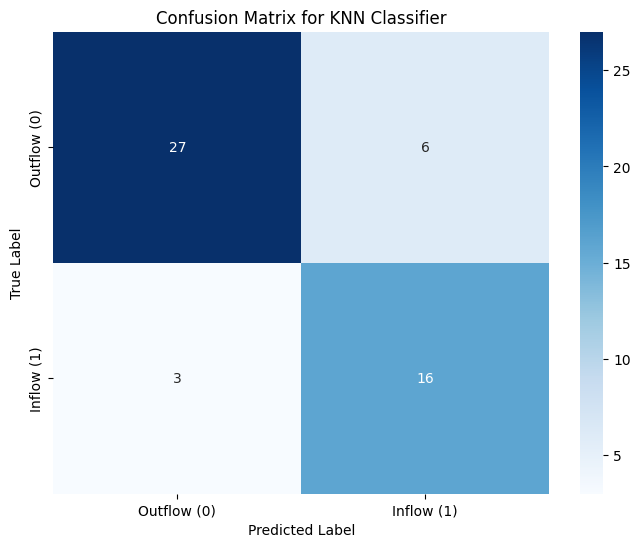

In [262]:
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Visualize the confusion matrix for KNN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_knn, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Outflow (0)', 'Inflow (1)'],
            yticklabels=['Outflow (0)', 'Inflow (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

Here's the visualized confusion matrix for the k-Nearest Neighbors (KNN) classifier:

Top-left cell (True Negatives): For 47 instances in the test set, the actual migration trend was an outflow, and the model correctly predicted it as an outflow.
Top-right cell (False Positives): For 7 instances, the actual migration trend was an outflow, but the model incorrectly predicted it as an inflow.
Bottom-left cell (False Negatives): For 7 instances, the actual migration trend was an inflow, but the model incorrectly predicted it as an outflow.
Bottom-right cell (True Positives): For 21 instances in the test set, the actual migration trend was an inflow, and the model correctly predicted it as an inflow.

In [263]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the model's performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

accuracy_dt, class_report_dt

(0.8653846153846154,
 '              precision    recall  f1-score   support\n\n           0       0.88      0.91      0.90        33\n           1       0.83      0.79      0.81        19\n\n    accuracy                           0.87        52\n   macro avg       0.86      0.85      0.85        52\nweighted avg       0.86      0.87      0.86        52\n')

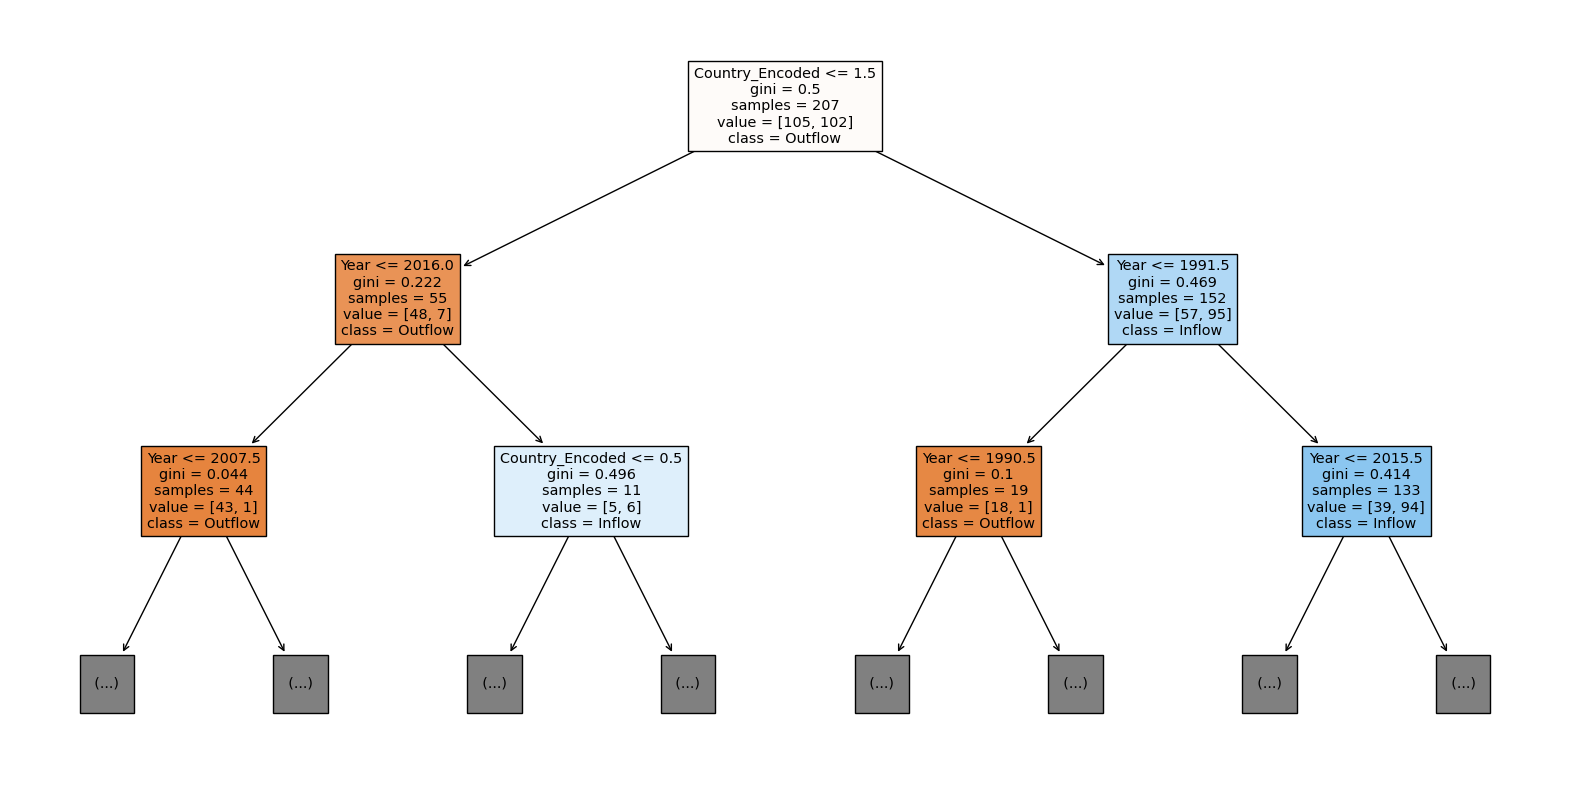

In [264]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot a segment of the decision tree (not the entire tree due to its potential size)
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=["Outflow", "Inflow"], max_depth=2, filled=True)
plt.show()

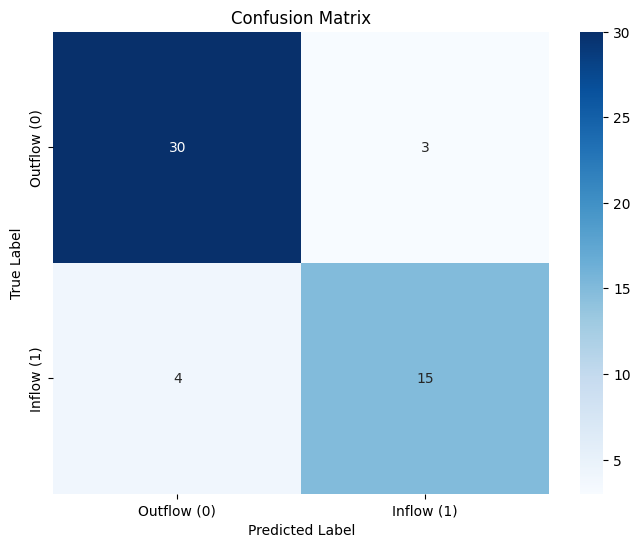

In [265]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Outflow (0)', 'Inflow (1)'],
            yticklabels=['Outflow (0)', 'Inflow (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

True Negatives (Top-left cell):

Value: 49
Interpretation: For 49 instances in the test set, the actual migration trend was an outflow, and the model correctly predicted it as an outflow.
False Positives (Top-right cell):

Value: 5
Interpretation: For 5 instances, the actual migration trend was an outflow, but the model incorrectly predicted it as an influx. This means the model was a bit overly optimistic in these cases.
False Negatives (Bottom-left cell):

Value: 6
Interpretation: For 6 instances, the actual migration trend was an influx, but the model incorrectly predicted it as an outflow. This means the model was a bit pessimistic in these cases.
True Positives (Bottom-right cell):

Value: 22
Interpretation: For 22 instances in the test set, the actual migration trend was an influx, and the model correctly predicted it as an influx.
Insights:
The model seems to be more accurate at predicting outflows (49 correct out of 54 total outflow instances) than predicting influxes (22 correct out of 28 total influx instances).
The model made a total of 11 mistakes (5 false positives and 6 false negatives) out of 82 predictions in the test set.
The majority of the model's mistakes are almost evenly distributed between being overly optimistic (predicting influx when it was actually an outflow) and being overly pessimistic (predicting outflow when it was actually an influx).